In [1]:
import torch
import torch.nn.functional as F
import glob
import random
from torchsummary import summary
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from prefetch_generator import BackgroundGenerator
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from collections import defaultdict
from math import sqrt
from functools import reduce
import numpy as np
import math
from PIL import Image
from torchsummary import summary
import time
cudnn.enabled = True
cudnn.benchmark = True

In [2]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [3]:
class SEBlock(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.globalavgpooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(c_in, max(1, c_in // 16))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(max(1, c_in // 16), c_in)
        self.sigmoid = nn.Sigmoid()
        self.c_in = c_in
    
    def forward(self, x):
        assert self.c_in == x.size(1)
        x = self.globalavgpooling(x)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.sigmoid(x)
        return x


class IBN(nn.Module):
    def __init__(self, in_channels, ratio=0.5):
        """
        Some do instance norm, some do batch norm
        """
        super().__init__()
        self.in_channels = in_channels
        self.ratio = ratio
        self.half = int(self.in_channels * ratio)
        self.IN = nn.InstanceNorm2d(self.half, affine=True)
        self.BN = nn.BatchNorm2d(self.in_channels - self.half)
    
    def forward(self, x):
        split = torch.split(x, self.half, 1)
        out1 = self.IN(split[0].contiguous())
        out2 = self.BN(split[1].contiguous())
        out = torch.cat((out1, out2), 1)
        return out


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


class SEDense18_IBN(nn.Module):
    def __init__(self, num_class=751, needs_norm=True, is_reid=False):
        super().__init__()
        model = models.resnet18(pretrained=True)
        self.conv0 = model.conv1
        self.bn0 = model.bn1
        self.relu0 = model.relu
        self.pooling0 = model.maxpool

        model.layer1[0].bn1 = IBN(64)
        self.basicBlock11 = model.layer1[0]
        self.seblock1 = SEBlock(64)

        self.basicBlock12 = model.layer1[1]
        self.seblock2 = SEBlock(64)

        model.layer2[0].bn1 = IBN(128)
        self.basicBlock21 = model.layer2[0]
        self.seblock3 = SEBlock(128)
        self.ancillaryconv3 = nn.Conv2d(64, 128, 1, 2, 0)
        self.optionalNorm2dconv3 = nn.BatchNorm2d(128)

        self.basicBlock22 = model.layer2[1]
        self.seblock4 = SEBlock(128)
        
        model.layer3[0].bn1 = IBN(256)
        self.basicBlock31 = model.layer3[0]
        self.seblock5 = SEBlock(256)
        self.ancillaryconv5 = nn.Conv2d(128, 256, 1, 2, 0)
        self.optionalNorm2dconv5 = nn.BatchNorm2d(256)

        self.basicBlock32 = model.layer3[1]
        self.seblock6 = SEBlock(256)

        self.basicBlock41 = model.layer4[0]
        # last stride = 1
        self.basicBlock41.conv1 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, device="cuda:0")
        self.basicBlock41.downsample[0] = nn.Conv2d(256, 512, kernel_size=(1,1), stride=(1,1), bias=False, device="cuda:0")
        self.seblock7 = SEBlock(512)
        self.ancillaryconv7 = nn.Conv2d(256, 512, 1, 1, 0)
        self.optionalNorm2dconv7 = nn.BatchNorm2d(512)

        self.basicBlock42 = model.layer4[1]
        self.seblock8 = SEBlock(512)

        self.avgpooling = model.avgpool
        # self.avgpooling = GeM()

        self.bnneck = nn.BatchNorm1d(512)
        self.bnneck.bias.requires_grad_(False)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_class),
        )
        self.needs_norm = needs_norm
        self.is_reid = is_reid
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.pooling0(x)
        branch1 = x
        x = self.basicBlock11(x)
        scale1 = self.seblock1(x)
        x = scale1 * x + branch1

        branch2 = x
        x = self.basicBlock12(x)
        scale2 = self.seblock2(x)
        x = scale2 * x + branch2

        branch3 = x
        x = self.basicBlock21(x)
        scale3 = self.seblock3(x)
        if self.needs_norm:
            x = scale3 * x + self.optionalNorm2dconv3(self.ancillaryconv3(branch3))
        else:
            x = scale3 * x + self.ancillaryconv3(branch3)

        branch4 = x
        x = self.basicBlock22(x)
        scale4 = self.seblock4(x)
        x = scale4 * x + branch4

        branch5 = x
        x = self.basicBlock31(x)
        scale5 = self.seblock5(x)
        if self.needs_norm:
            x = scale5 * x + self.optionalNorm2dconv5(self.ancillaryconv5(branch5))
        else:
            x = scale5 * x + self.ancillaryconv5(branch5)

        branch6 = x
        x = self.basicBlock32(x)
        scale6 = self.seblock6(x)
        x = scale6 * x + branch6

        branch7 = x
        x = self.basicBlock41(x)
        scale7 = self.seblock7(x)
        if self.needs_norm:
            x = scale7 * x + self.optionalNorm2dconv7(self.ancillaryconv7(branch7))
        else:
            x = scale7 * x + self.ancillaryconv7(branch7)

        branch8 = x
        x = self.basicBlock42(x)
        scale8 = self.seblock8(x)
        x = scale8 * x + branch8

        x = self.avgpooling(x)
        feature = x.view(x.size(0), -1)
        if self.is_reid:
            return feature
        x = self.bnneck(feature)
        x = self.classifier(x)

        return x, feature

In [4]:
def relabel(label_set):
    label = 0
    latest_label = label_set[0]
    new_label_set = list()
    for cur_label in label_set:
        if cur_label != latest_label:
            label += 1
            latest_label = cur_label
        new_label_set.append(label)
    return new_label_set


image_path = sorted(glob.glob("../../Market-1501/bounding_box_train/*.jpg"))
label_path = list(map(lambda x: int(x.split("/")[-1][:4]), image_path))
label_path = relabel(label_path)
assert max(label_path) == 750

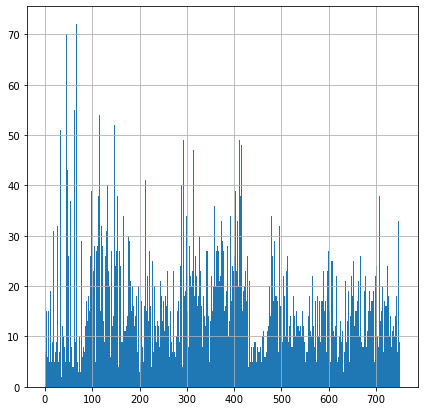

11265


In [5]:
def check_distribution(label_path):
    unique, counts = np.unique(np.asarray(label_path), return_counts=True)
    plt.figure(figsize=(7,7))
    plt.bar(unique, counts, width=1)
    plt.grid()
    plt.show()
    return np.median(counts)

# I am not sure how to set the baseline. Let's try 15 as it is the median
def augmentation(images, transform, num):
    augments = list()
    for _ in range(num):
        reference = np.random.choice(len(images))
        augments.append(transform(images[reference]))
    images.extend(augments)
    return images

def reorganize(image_path, label_path, base=15):
    d = defaultdict(list)
    for i, image in enumerate(image_path):
        image_ = Image.open(image).convert("RGB")
        image_ = transforms.ToTensor()(image_)
        d[label_path[i]].append(image_)
    for key in d:
        if len(d[key]) >= base:
            # sample
            indices = np.random.choice(len(d[key]), size=base, replace=False)
            original = d[key][:]
            d[key].clear()
            for indice in indices:
                d[key].append(original[indice])
        else:
            # augment
            transform = transforms.Compose([
                transforms.RandomErasing(),
                transforms.RandomHorizontalFlip(),                           
            ])
            d[key] = augmentation(d[key], transform, base-len(d[key]))
    balanced_label_path = []
    for i in range(len(d)):
        balanced_label_path.extend([i for _ in range(base)])
    balanced_image_path = []
    for label in range(len(d)):
        balanced_image_path.extend(d[label])
    return balanced_image_path, balanced_label_path # tensors, list[int]

base = check_distribution(label_path)
balanced_image_path, balanced_label_path = reorganize(image_path, label_path, int(base))
print(len(balanced_image_path)) # much larger than the previous dataset

In [6]:
class BalancedDataset(Dataset):
    def __init__(self, image_path, label_path, transform):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image = self.image_path[idx]
        label = self.label_path[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label).int()

In [7]:
class LabelSmoothing(nn.Module):
    """ NLL loss with label smoothing. """

    def __init__(self, smoothing=0.1):
        """ Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        target = target.long()
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [8]:
class CenterLoss(nn.Module):
    """Center loss.
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
 
    def __init__(self, num_classes=751, feat_dim=2048, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
 
        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))
 
    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (num_classes).
        """
        assert x.size(0) == labels.size(0), "features.size(0) is not equal to labels.size(0)"
 
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())
 
        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))
 
        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12)  # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()
        return loss


class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    
    Reference:
        Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    
    Imported from `<https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py>`_.
    
    Args:
        margin (float, optional): margin for triplet. Default is 0.3.
    """
    
    def __init__(self, margin=0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
 
    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): feature matrix with shape (batch_size, feat_dim).
            targets (torch.LongTensor): ground truth labels with shape (num_classes).
        """
        n = inputs.size(0)
        
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        return self.ranking_loss(dist_an, dist_ap, y)

In [9]:
class HybridLoss3(nn.Module):
    def __init__(self, num_classes, feat_dim=512, margin=0.3, smoothing=0.1):
        super().__init__()
        self.center = CenterLoss(num_classes=num_classes, feat_dim=feat_dim)
        self.triplet = TripletLoss(margin)
        self.smooth = LabelSmoothing(smoothing)

    def forward(self, embeddings, outputs, targets):
        """
        features: feature vectors
        targets: ground truth labels
        """
        smooth_loss = self.smooth(outputs, targets)
        triplet_loss = self.triplet(embeddings, targets)
        center_loss = self.center(embeddings, targets)
        return smooth_loss + triplet_loss + 0.0005 * center_loss

In [10]:
from bisect import bisect_right


class WarmupMultiStepLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        milestones,
        gamma=0.1,
        warmup_factor=1.0 / 3,
        warmup_iters=300,
        warmup_method="linear",
        last_epoch=-1,
    ):
        if not list(milestones) == sorted(milestones):
            raise ValueError(
                "Milestones should be a list of" " increasing integers. Got {}",
                milestones,
            )

        if warmup_method not in ("constant", "linear"):
            raise ValueError(
                "Only 'constant' or 'linear' warmup_method accepted"
                "got {}".format(warmup_method)
            )
        self.milestones = milestones
        self.gamma = gamma
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        self.warmup_method = warmup_method
        super(WarmupMultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        warmup_factor = 1
        if self.last_epoch < self.warmup_iters:
            if self.warmup_method == "constant":
                warmup_factor = self.warmup_factor
            elif self.warmup_method == "linear":
                alpha = self.last_epoch / self.warmup_iters
                warmup_factor = self.warmup_factor * (1 - alpha) + alpha
        return [
            base_lr
            * warmup_factor
            * self.gamma ** bisect_right(self.milestones, self.last_epoch)
            for base_lr in self.base_lrs
        ]

In [11]:
def train_strategy2(num_classes):
    model = SEDense18_IBN(num_class=num_classes, is_reid=False).cuda()
    loss_function = HybridLoss3(num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 150)
    return model, loss_function, optimizer, lr_scheduler

In [12]:
def train3(image_path, label_path, num_class, epochs=10, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((128, 64)),
        transforms.Pad(10),
        transforms.RandomCrop((128, 64)), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    reid_dataset = BalancedDataset(image_path, label_path, transform)
    losses_func = list()
    model, loss_func, optim_func, lr_func = train_strategy2(num_class)
    model.train()
    for epoch in range(epochs):
        dataloader = DataLoaderX(reid_dataset, batch_size, True, num_workers=4, pin_memory=True, drop_last=True)
        iterator = tqdm(dataloader)
        for sample in iterator:
            optim_func.zero_grad()
            image, label = sample
            image, label = image.cuda(), label.cuda()
            
            prediction, feature = model(image)

            loss = loss_func(feature, prediction, label)

            losses_func.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10.)
            optim_func.step()
            lr_func.step()
            status = "epoch: {}, lr: {:.6f}, loss: {:.4f}".format(epoch, lr_func.get_last_lr()[0], loss.item())
            iterator.set_description(status)
    model = model.eval()
    return model, losses_func


def plot_losses3(losses_func):
    plt.figure()
    plt.plot(losses_func, linewidth=2, color="r", label="training loss")
    plt.xlabel("iterations")
    plt.ylabel("loss value")
    plt.title("loss functions")
    plt.legend()
    plt.grid()
    plt.show()

  0%|          | 0/176 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
epoch: 39, lr: 0.000011, loss: 1.8209: 100%|██████████| 176/176 [00:22<00:00,  7.93it/s]


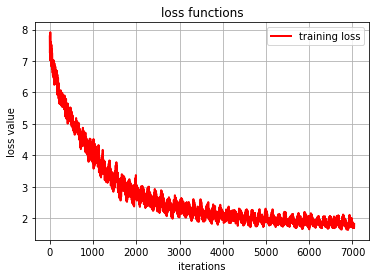

In [13]:
model, losses = train3(balanced_image_path, balanced_label_path, max(label_path)+1, 40)
plot_losses3(losses)

In [14]:
overall_model = SEDense18_IBN().cuda()
overall_model.load_state_dict(model.state_dict())
torch.save(overall_model.state_dict(), "SE18_IBN_balanced_checkpoint.pt")